<a href="https://colab.research.google.com/github/fjadidi2001/Image_Inpaint/blob/main/21Nov_Crashed_U_net%2BxLSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!nvidia-smi

Sun Dec 21 04:31:47 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   41C    P8              9W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [2]:
import kagglehub
dataset_path=kagglehub.dataset_download("badasstechie/celebahq-resized-256x256")

!ls {dataset_path}/celeba_hq_256 | head

dataset_path=f'{dataset_path}/celeba_hq_256'

100%|██████████| 283M/283M [00:01<00:00, 150MB/s]

Extracting files...


00000.jpg
00001.jpg
00002.jpg
00003.jpg
00004.jpg
00005.jpg
00006.jpg
00007.jpg
00008.jpg
00009.jpg


In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
from torchvision.utils import save_image

import numpy as np
import matplotlib.pyplot as plt
import cv2
from PIL import Image
import os
from tqdm import tqdm
import random
from sklearn.model_selection import train_test_split
import pandas as pd
import seaborn as sns
import glob


# assert(torch.cuda.is_available())
# torch.set_default_device('cpu')


In [4]:
DEVICE = torch.device('cuda')
IMG_WIDTH=256
IMG_HEIGHT=256
BATCH_SIZE = 32
LEARNING_RATE = 0.001



class InpaintingDataset(Dataset):
    def __init__(self, image_paths, transform=None):
        self.image_paths = image_paths
        self.transform = transform

    def create_mask(self):
        mask = torch.ones((1, IMG_HEIGHT,IMG_WIDTH ))
        y1, x1 = random.randint(0, IMG_HEIGHT - IMG_HEIGHT//3), random.randint(0, IMG_WIDTH - IMG_WIDTH//3)
        h, w = IMG_HEIGHT//3, IMG_WIDTH//3
        mask[:, y1:y1+h, x1:x1+w] = 0
        return mask

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        img = Image.open(img_path).convert('RGB')

        if self.transform:
            img = self.transform(img)

        mask = self.create_mask()
        masked_img = img * mask

        # print(f"Image device: {img.device}")
        # print(f"Mask device: {mask.device}")
        # print(f"Masked image device: {masked_img.device}")

        return masked_img, mask, img

    def __len__(self):
        return len(self.image_paths)

class UNet(nn.Module):
    def __init__(self):
        super(UNet, self).__init__()

        # Encoder
        self.enc1 = self.double_conv(3, 64)
        self.enc2 = self.double_conv(64, 128)
        self.enc3 = self.double_conv(128, 256)

        # Decoder
        self.dec3 = self.double_conv(256 + 128, 128)
        self.dec2 = self.double_conv(128 + 64, 64)
        self.dec1 = nn.Conv2d(64, 3, kernel_size=1)

        self.pool = nn.MaxPool2d(2)
        self.upsample = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)

    def double_conv(self, in_channels, out_channels):
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, 3, padding=1),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        # Encoder
        e1 = self.enc1(x)
        e2 = self.enc2(self.pool(e1))
        e3 = self.enc3(self.pool(e2))

        # Decoder
        d3 = self.dec3(torch.cat([self.upsample(e3), e2], dim=1))
        d2 = self.dec2(torch.cat([self.upsample(d3), e1], dim=1))
        return torch.sigmoid(self.dec1(d2))

class HINT(nn.Module):
    def __init__(self, dim=64, num_heads=4):
        super(HINT, self).__init__()

        self.input_conv = nn.Conv2d(4, dim, 3, padding=1)  # 3 channels + 1 mask channel

        # Transformer blocks
        self.transformer_blocks = nn.ModuleList([
            nn.Sequential(
                nn.MultiheadAttention(dim, num_heads),
                nn.LayerNorm(dim),
                nn.Linear(dim, dim * 2),
                nn.ReLU(),
                nn.Linear(dim * 2, dim),
                nn.LayerNorm(dim)
            ) for _ in range(3)
        ])

        self.output_conv = nn.Conv2d(dim, 3, 1)

    def forward(self, x, mask):
        # Combine input and mask
        x = torch.cat([x, mask], dim=1)
        x = self.input_conv(x)

        # Reshape for transformer
        b, c, h, w = x.shape
        x = x.flatten(2).permute(2, 0, 1)  # (h*w, batch, channels)

        # Apply transformer blocks
        for block in self.transformer_blocks:
            attn, _ = block[0](x, x, x)
            x = x + attn
            x = block[1](x)
            x = x + block[4](block[3](block[2](x)))
            x = block[5](x)

        # Reshape back
        x = x.permute(1, 2, 0).view(b, c, h, w)
        x = self.output_conv(x)
        return torch.sigmoid(x)

class XLSTM(nn.Module):
    def __init__(self, hidden_size=64):
        super(XLSTM, self).__init__()

        self.conv_init = nn.Conv2d(3, hidden_size, 3, padding=1)

        # LSTM cells for different directions
        self.lstm_h = nn.LSTMCell(hidden_size, hidden_size)
        self.lstm_v = nn.LSTMCell(hidden_size, hidden_size)
        self.lstm_d = nn.LSTMCell(hidden_size, hidden_size)

        self.conv_out = nn.Conv2d(hidden_size, 3, 1)

    def forward(self, x):
        b, _, h, w = x.shape
        hidden_size = 64

        # Initial feature extraction
        feat = self.conv_init(x)

        # Initialize hidden states
        h_state = torch.zeros(b, hidden_size, device=x.device)
        c_state = torch.zeros(b, hidden_size, device=x.device)

        # Process in different directions
        for i in range(h):
            for j in range(w):
                feat_ij = feat[:, :, i, j]
                h_state, c_state = self.lstm_h(feat_ij, (h_state, c_state))
                feat[:, :, i, j] = h_state

        # Vertical processing
        for j in range(w):
            for i in range(h):
                feat_ij = feat[:, :, i, j]
                h_state, c_state = self.lstm_v(feat_ij, (h_state, c_state))
                feat[:, :, i, j] = h_state

        # Diagonal processing
        for k in range(h + w - 1):
            for i in range(max(0, k-w+1), min(h, k+1)):
                j = k - i
                if j < w:
                    feat_ij = feat[:, :, i, j]
                    h_state, c_state = self.lstm_d(feat_ij, (h_state, c_state))
                    feat[:, :, i, j] = h_state

        return torch.sigmoid(self.conv_out(feat))

class CombinedModel(nn.Module):
    def __init__(self, unet, hint, xlstm):
        super(CombinedModel, self).__init__()
        self.unet = unet
        self.hint = hint
        self.xlstm = xlstm
        self.weights = nn.Parameter(torch.ones(3))  # Learnable weights for each model

    def forward(self, x, mask):
        unet_out = self.unet(x)
        hint_out = self.hint(x, mask)
        xlstm_out = self.xlstm(x)

        weights = torch.softmax(self.weights, dim=0)
        combined = (weights[0] * unet_out +
                   weights[1] * hint_out +
                   weights[2] * xlstm_out)
        return combined



def train_model(model, train_loader, criterion, optimizer, epoch: int, model_name):
    model.train()

    epoch_loss = 0
    for masked_imgs, masks, original_imgs in tqdm(train_loader):
        masked_imgs = masked_imgs.to(DEVICE)
        masks = masks.to(DEVICE)
        original_imgs = original_imgs.to(DEVICE)

        optimizer.zero_grad()

        if isinstance(model, HINT):
            outputs = model(masked_imgs, masks)
        elif isinstance(model, (UNet, XLSTM)):
            outputs = model(masked_imgs)
        else:  # Combined model
            outputs = model(masked_imgs, masks)

        loss = criterion(outputs, original_imgs)
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()
        # print(f'Loss: {loss.item():.4f}')


    avg_loss = epoch_loss / len(train_loader)
    print(f'Epoch {epoch}, Loss: {avg_loss:.4f}')

    return avg_loss

def evaluate_models(models, test_loader):
    metrics = {
        'PSNR': [],
        'SSIM': [],
        'L1_Loss': []
    }

    for name, model in models.items():
        model.eval()
        psnr_values = []
        ssim_values = []
        l1_values = []

        with torch.no_grad():
            for masked_imgs, masks, original_imgs in test_loader:
                masked_imgs = masked_imgs.to(DEVICE)
                masks = masks.to(DEVICE)
                original_imgs = original_imgs.to(DEVICE)

                if isinstance(model, HINT):
                    outputs = model(masked_imgs, masks)
                elif isinstance(model, (UNet, XLSTM)):
                    outputs = model(masked_imgs)
                else:  # Combined model
                    outputs = model(masked_imgs, masks)

                # Calculate metrics
                psnr = -10 * torch.log10(torch.mean((original_imgs - outputs) ** 2))
                l1 = torch.mean(torch.abs(original_imgs - outputs))

                psnr_values.append(psnr.item())
                l1_values.append(l1.item())

        metrics['PSNR'].append(np.mean(psnr_values))
        metrics['L1_Loss'].append(np.mean(l1_values))

    return pd.DataFrame(metrics, index=list(models.keys()))




In [5]:
CHECKPOINT_DIR = './checkpoints'
os.makedirs(CHECKPOINT_DIR, exist_ok=True)

def save_checkpoint(model, optimizer, epoch, model_name):
    checkpoint_path = os.path.join(CHECKPOINT_DIR, f'{model_name}_epoch_{epoch}.pth')
    torch.save({
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
    }, checkpoint_path)
    print(f"ckpt saved for {model_name} at epoch {epoch}.")

def load_checkpoint(model, optimizer, model_name):
    checkpoints = [f for f in os.listdir(CHECKPOINT_DIR) if model_name in f]
    if not checkpoints:
        print(f"no ckpt found for {model_name} starting from epoch 0.")
        return 0

    latest_checkpoint = sorted(checkpoints)[-1]
    checkpoint_path = os.path.join(CHECKPOINT_DIR, latest_checkpoint)
    checkpoint = torch.load(checkpoint_path)

    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    start_epoch = checkpoint['epoch'] + 1
    print(f"ckpt loaded for {model_name} from {latest_checkpoint}. start from epoch {start_epoch}.")

    return start_epoch

In [ ]:
# Set up data transforms
transform = transforms.Compose([
    transforms.Resize((IMG_HEIGHT, IMG_WIDTH)),
    transforms.ToTensor()
])

    # Load dataset
image_paths = glob.glob(f'{dataset_path}/*.jpg')
print(len(image_paths))
# Split dataset
train_paths, test_paths = train_test_split(image_paths, test_size=0.9, random_state=42)


train_dataset = InpaintingDataset(train_paths, transform=transform)
test_dataset = InpaintingDataset(test_paths, transform=transform)


train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=True)


unet = UNet().to(DEVICE)
hint = HINT().to(DEVICE)
xlstm = XLSTM().to(DEVICE)
combined = CombinedModel(unet, hint, xlstm).to(DEVICE)

criterion = nn.MSELoss()
models = {
    'unet': (unet, optim.Adam(unet.parameters(), lr=LEARNING_RATE)),
    'hint': (hint, optim.Adam(hint.parameters(), lr=LEARNING_RATE)),
    'xlstm': (xlstm, optim.Adam(xlstm.parameters(), lr=LEARNING_RATE)),
    'combined': (combined, optim.Adam(combined.parameters(), lr=LEARNING_RATE))
}

for model_name, (model, optimizer) in models.items():
    print(f"\nTraining {model_name}")
    start_epoch = load_checkpoint(model, optimizer, model_name)

    losses = []
    for epoch in range(start_epoch, 5): #assuming we wanna train for 5 epochs. likely reconfigurable later
        model.train()
        loss = train_model(model, train_loader, criterion, optimizer, epoch=epoch, model_name=model_name)
        losses.append(loss)

        save_checkpoint(model, optimizer, epoch, model_name)

        plt.figure(figsize=(10, 5))
        plt.plot(losses)
        plt.title(f'{model_name} Training Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.savefig(f'{model_name}_training_loss.png')
        plt.close()

    results = evaluate_models(
        {name: model for name, (model, _) in models.items()},
        test_loader
    )
    print("\nEvaluation Results:")
    print(results)


30000

Training unet
no ckpt found for unet starting from epoch 0.


100%|██████████| 94/94 [01:44<00:00,  1.12s/it]


Epoch 0, Loss: 0.0228
ckpt saved for unet at epoch 0.


100%|██████████| 94/94 [01:45<00:00,  1.12s/it]


Epoch 1, Loss: 0.0096
ckpt saved for unet at epoch 1.


100%|██████████| 94/94 [01:45<00:00,  1.12s/it]


Epoch 2, Loss: 0.0065
ckpt saved for unet at epoch 2.


 85%|████████▌ | 80/94 [01:29<00:15,  1.11s/it]

In [ ]:
test_dataset[0]

# FJ V

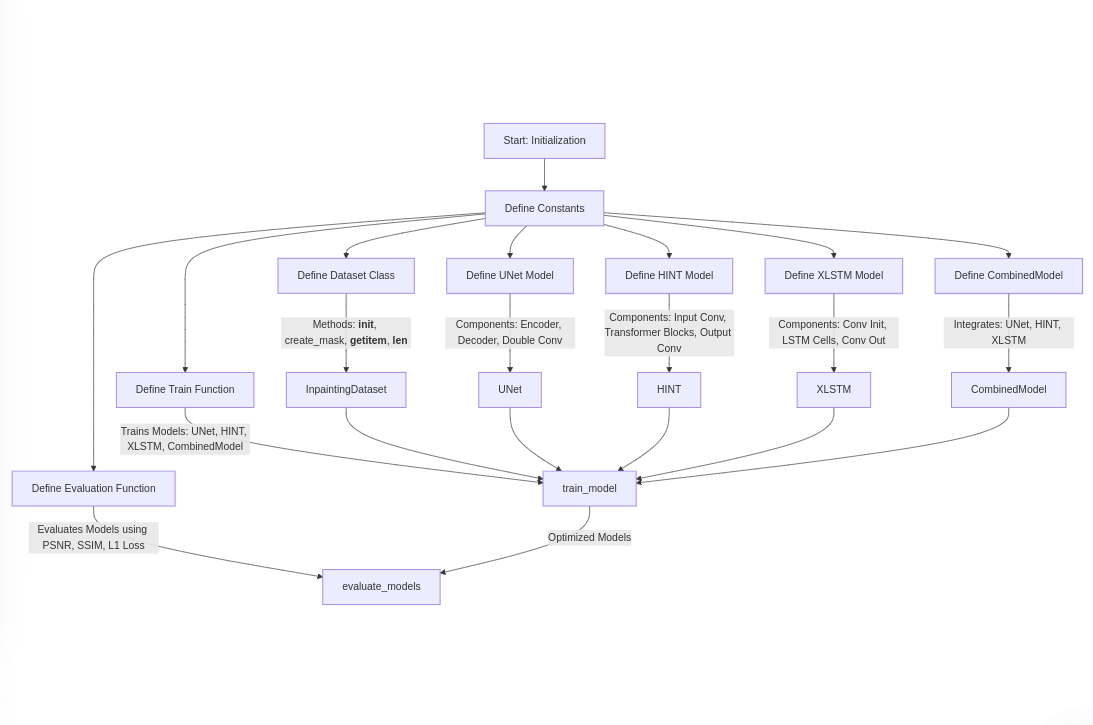